In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

## EDA

In [218]:
ds = load_dataset("allenai/multixscience_sparse_mean")

train_df = ds["train"].to_pandas()

print(f"Jumlah baris data {train_df.shape[0]}")
train_df.head()

Jumlah baris data 30369


,aid,mid,abstract,related_work,ref_abstract
0,math9912167,1631980677,"Author(s): Kuperberg, Greg; Thurston, Dylan P....",Two other generalizations that can be consider...,"{'cite_N': ['@cite_16', '@cite_26'], 'mid': ['..."
1,cs9910011,2168463568,A statistical model for segmentation and word ...,"Model Based Dynamic Programming, hereafter ref...","{'cite_N': ['@cite_0'], 'mid': ['2074546930'],..."
2,cs9911003,2950670108,We solve the subgraph isomorphism problem in p...,Recently we were able to characterize the grap...,"{'cite_N': ['@cite_41'], 'mid': ['2074992286']..."
3,hep-th9908200,2160091034,Daviau showed the equivalence of matrix Dirac ...,A further genuine and important approach to th...,"{'cite_N': ['@cite_6'], 'mid': ['2082565556'],..."
4,cs9903014,1612660921,We present an open architecture for just-in-ti...,Pioneering research in dynamic runtime optimiz...,"{'cite_N': ['@cite_8'], 'mid': ['2101776604'],..."


In [219]:
print('===== Format ref abstract =====\n')
for index, (key, value) in enumerate((train_df['ref_abstract'][0]).items()):
    print(f"{key} : ")
    for i in value:
        print(f"\t- {i[:100]}...")
    print("\n")

===== Format ref abstract =====

cite_N : 
	- @cite_16...
	- @cite_26...


mid : 
	- 1481005306...
	- 1641082372...


abstract : 
	- This note is a sequel to our earlier paper of the same title [4] and describes invariants of rationa...
	- Recently, Mullins calculated the Casson-Walker invariant of the 2-fold cyclic branched cover of an o...




In [220]:
def get_ref_stats(row):
    refs = row['ref_abstract']
    
    if not refs or 'abstract' not in refs:
        return 0, 0, 0
    
    ref_abstracts = refs['abstract']
    
    num_refs = len(ref_abstracts)

    context_text = " ".join([txt for txt in ref_abstracts if txt])
    context_len = len(context_text.split()) # Estimasi kata

    empty_refs = sum(1 for txt in ref_abstracts if not txt or len(txt.strip()) < 10)
    
    return num_refs, context_len, empty_refs

df_eda = train_df.copy()

stats = df_eda.apply(get_ref_stats, axis=1, result_type='expand')
df_eda[['num_refs', 'context_word_count', 'empty_refs_count']] = stats

df_eda['target_word_count'] = df_eda['related_work'].astype(str).apply(lambda x: len(x.split()))

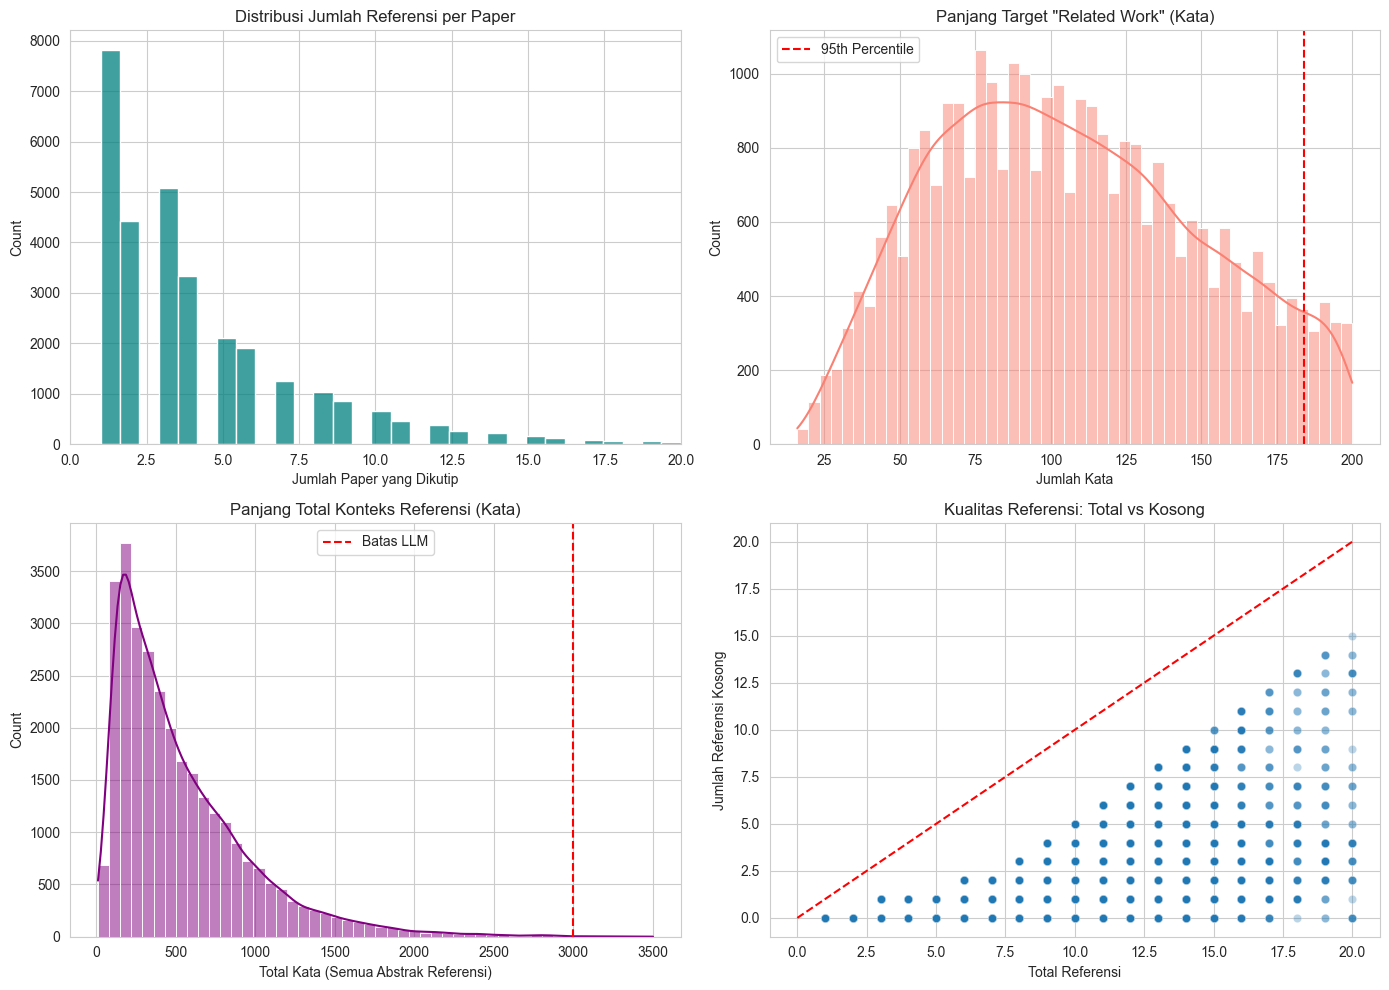


=== INSIGHT PANJANG KATA ===
Rata-rata Jumlah Referensi : 4.1 paper
Max Target Length (95%)    : 184 kata (~239 token)
Max Context Length (95%)   : 1387 kata (~1803 token)

Data dengan referensi kosong : 11032 baris (36.3%)


In [221]:
# --- 2. VISUALISASI DISTRIBUSI ---

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot A: Berapa banyak referensi yang dikutip?
sns.histplot(df_eda['num_refs'], bins=30, kde=False, ax=axes[0,0], color='teal')
axes[0,0].set_title('Distribusi Jumlah Referensi per Paper')
axes[0,0].set_xlabel('Jumlah Paper yang Dikutip')
axes[0,0].set_xlim(0, 20) # Zoom in ke range wajar

# Plot B: Seberapa panjang bab Related Work aslinya? (Target Length)
sns.histplot(df_eda['target_word_count'], bins=50, kde=True, ax=axes[0,1], color='salmon')
axes[0,1].set_title('Panjang Target "Related Work" (Kata)')
axes[0,1].set_xlabel('Jumlah Kata')
axes[0,1].axvline(df_eda['target_word_count'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
axes[0,1].legend()

# Plot C: Seberapa panjang Total Context (Gabungan semua ref)? (Input Length)
sns.histplot(df_eda['context_word_count'], bins=50, kde=True, ax=axes[1,0], color='purple')
axes[1,0].set_title('Panjang Total Konteks Referensi (Kata)')
axes[1,0].set_xlabel('Total Kata (Semua Abstrak Referensi)')
# Garis batas token LLM (misal 4096 token approx 3000 kata)
axes[1,0].axvline(3000, color='red', linestyle='--', label='Batas LLM')
axes[1,0].legend()

# Apakah ada paper yang referensinya bolong?
sns.scatterplot(data=df_eda, x='num_refs', y='empty_refs_count', ax=axes[1,1], alpha=0.3)
axes[1,1].set_title('Kualitas Referensi: Total vs Kosong')
axes[1,1].set_xlabel('Total Referensi')
axes[1,1].set_ylabel('Jumlah Referensi Kosong')
axes[1,1].plot([0, 20], [0, 20], 'r--', label='Semua Kosong') # Garis diagonal

plt.tight_layout()
plt.show()

print("\n=== INSIGHT PANJANG KATA ===")
print(f"Rata-rata Jumlah Referensi : {df_eda['num_refs'].mean():.1f} paper")
print(f"Max Target Length (95%)    : {df_eda['target_word_count'].quantile(0.95):.0f} kata (~{int(df_eda['target_word_count'].quantile(0.95)*1.3)} token)")
print(f"Max Context Length (95%)   : {df_eda['context_word_count'].quantile(0.95):.0f} kata (~{int(df_eda['context_word_count'].quantile(0.95)*1.3)} token)")

# Cek data yang harus dibuang
bad_data = len(df_eda[df_eda['empty_refs_count'] > 0])
print(f"\nData dengan referensi kosong : {bad_data} baris ({bad_data/len(df_eda)*100:.1f}%)")

In [222]:
# Fungsi untuk mengecek integritas sitasi
def analyze_citation_integrity(row):
    related_text = row['related_work']
    refs = row['ref_abstract']
    
    if not isinstance(related_text, str) or not refs:
        return "No Data", 0
    
    # 1. Temukan semua token @cite_N di teks target
    # Regex menangkap @cite_0, @cite_12, dll
    citations_in_text = set(re.findall(r'@cite_\d+', related_text))
    
    # 2. Temukan semua token cite_N yang tersedia di metadata referensi
    citations_in_meta = set(refs.get('cite_N', []))
    
    # 3. Hitung Missing Citations (Halusinasi Data)
    # Sitasi ada di teks, tapi abstraknya TIDAK dikasih tau di input
    missing_refs = citations_in_text - citations_in_meta
    
    return list(missing_refs), len(citations_in_text)

# Fungsi cek Overlap Konten (ROUGE-1 sederhana)
def check_content_overlap(row):
    related_text = str(row['related_work']).lower().split()
    refs = row['ref_abstract']
    
    if not refs or 'abstract' not in refs:
        return 0.0
    
    # Gabungkan semua abstrak referensi jadi satu "bag of words"
    ref_content = set(" ".join(refs['abstract']).lower().split())
    
    # Hitung berapa % kata di related_work yang MUNCUL di referensi
    # (Kita abaikan stopwords sederhana biar cepat)
    target_words = set([w for w in related_text if len(w) > 3])
    if len(target_words) == 0: return 0.0
    
    overlap_count = sum(1 for w in target_words if w in ref_content)
    return overlap_count / len(target_words)

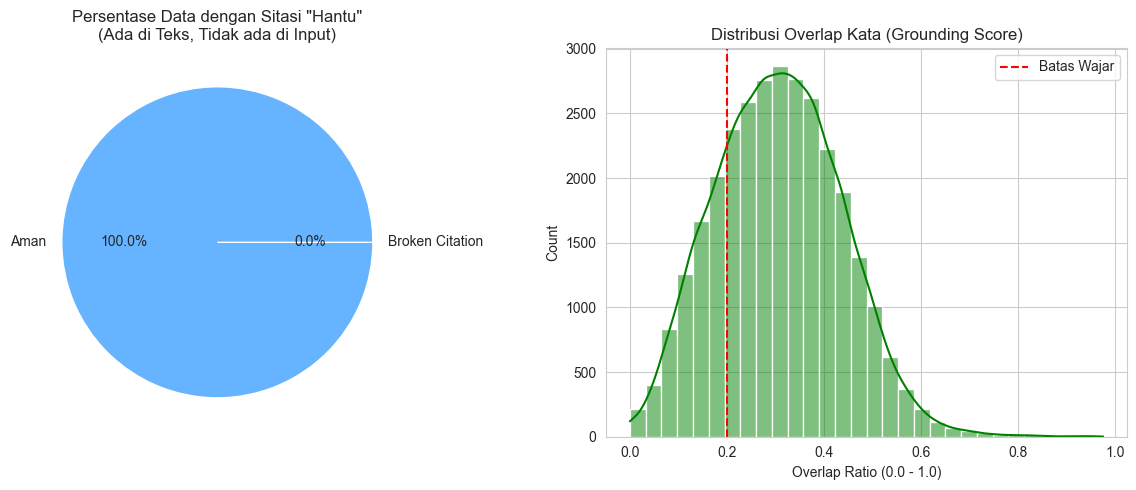

In [223]:
df_quality = train_df.copy()

integrity = df_quality.apply(analyze_citation_integrity, axis=1, result_type='expand')
df_quality['missing_citations'] = integrity[0]
df_quality['num_citations_in_text'] = integrity[1]

df_quality['content_overlap_score'] = df_quality.apply(check_content_overlap, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Masalah Sitasi Hilang
has_missing = df_quality['missing_citations'].apply(len) > 0
missing_percent = has_missing.mean() * 100

# Pie chart sederhana
axes[0].pie([100-missing_percent, missing_percent], labels=['Aman', 'Broken Citation'], 
            autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
axes[0].set_title(f'Persentase Data dengan Sitasi "Hantu"\n(Ada di Teks, Tidak ada di Input)')

# Seberapa Ngarang Tulisannya?
# Score rendah = Model menulis hal baru yang tidak ada di referensi (Hallucination/Abstractive banget)
# Score tinggi = Model banyak menyalin kata dari referensi (Extractive/Grounded)
sns.histplot(df_quality['content_overlap_score'], bins=30, ax=axes[1], color='green', kde=True)
axes[1].set_title('Distribusi Overlap Kata (Grounding Score)')
axes[1].set_xlabel('Overlap Ratio (0.0 - 1.0)')
axes[1].axvline(0.2, color='red', linestyle='--', label='Batas Wajar')
axes[1].legend()

plt.tight_layout()
plt.show()

=== HASIL ANALISIS & REKOMENDASI ===
1. Broken Citations: 0.0% data memiliki sitasi ke paper yang abstraknya TIDAK ADA.
   -> ACTION: Saat preprocessing, filter baris ini ATAU hapus token @cite_X yang hantu tersebut dari teks target.
2. Low Grounding: 6000-an data (21.5%) memiliki overlap kata < 20%.
   -> ACTION: Data ini mungkin terlalu abstrak/sulit. Pertimbangkan untuk membuangnya agar model lebih patuh pada referensi.

In [224]:
def analyze_row(row):
    # 1. Target: Related Work
    target_text = str(row['related_work'])
    target_len = len(target_text.split()) # Hitung kata
    
    # 2. Source: References
    refs = row['ref_abstract']
    if not refs or 'abstract' not in refs:
        num_refs = 0
        context_len = 0
        empty_refs = 0
    else:
        ref_list = refs['abstract']
        num_refs = len(ref_list)
        # Gabungkan semua abstrak referensi untuk hitung total panjang input
        combined_context = " ".join([str(txt) for txt in ref_list])
        context_len = len(combined_context.split())
        # Cek referensi kosong (biasanya string kosong atau sangat pendek)
        empty_refs = sum(1 for txt in ref_list if len(str(txt).strip()) < 5)
        
    return pd.Series([target_len, num_refs, context_len, empty_refs])

# Terapkan fungsi ke dataframe
# (Gunakan copy agar tidak merusak df asli)
df_eda[['target_len', 'num_refs', 'context_len', 'empty_refs']] = df_eda.apply(analyze_row, axis=1)

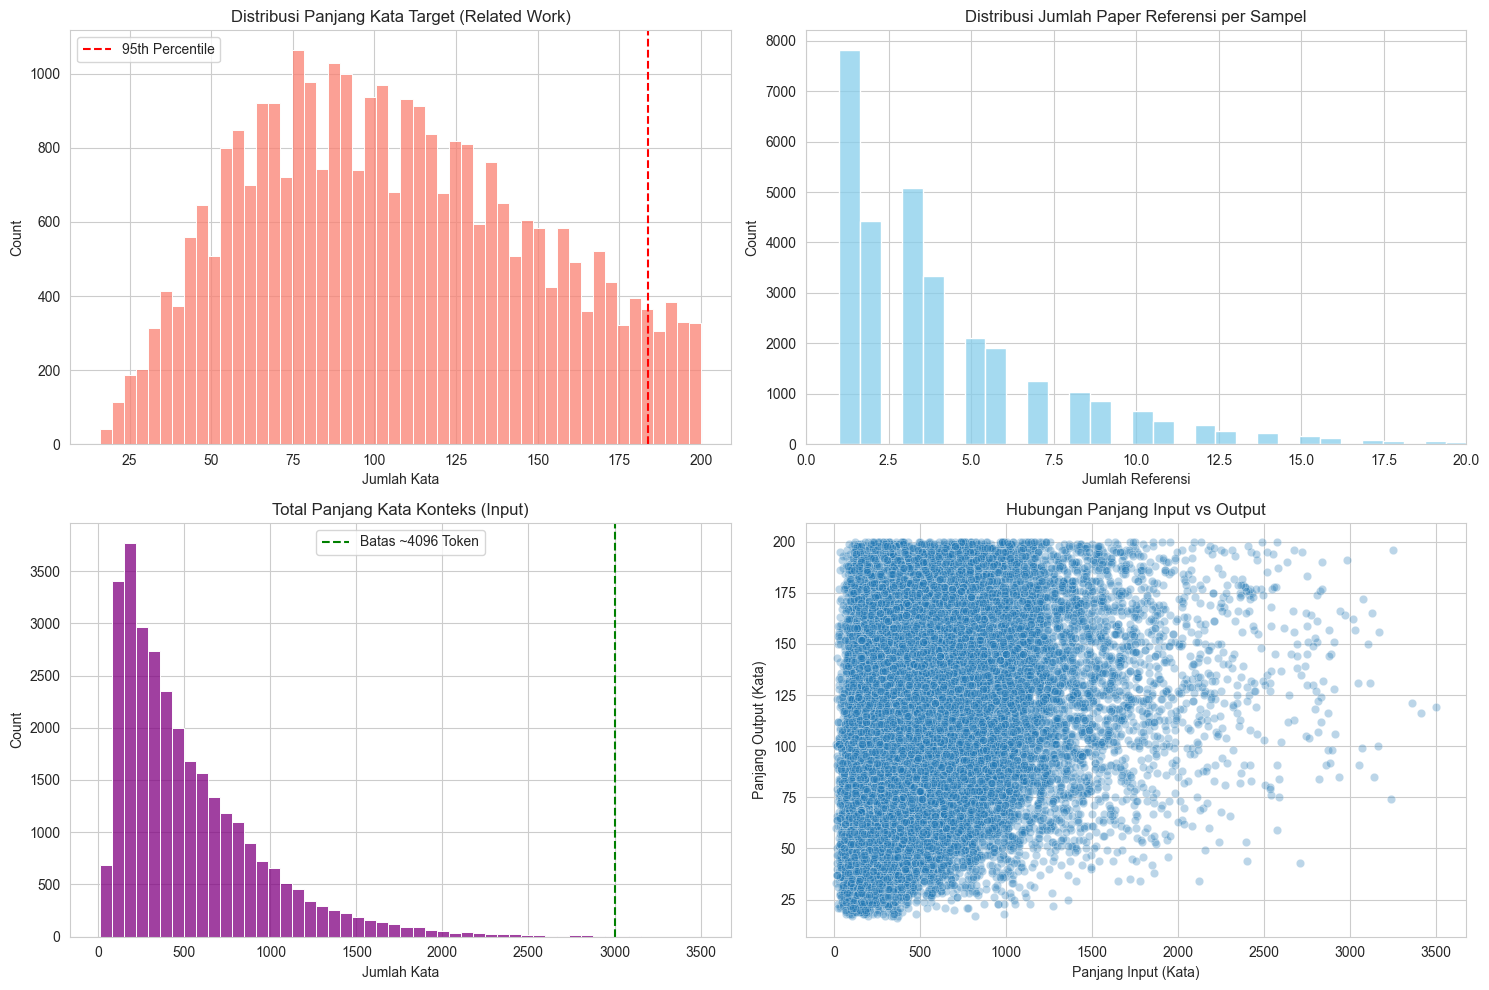

In [225]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.set_style("whitegrid")

# A. Distribusi Panjang Target (Related Work)
sns.histplot(df_eda['target_len'], bins=50, color='salmon', ax=axes[0,0])
axes[0,0].set_title('Distribusi Panjang Kata Target (Related Work)')
axes[0,0].set_xlabel('Jumlah Kata')
axes[0,0].axvline(df_eda['target_len'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
axes[0,0].legend()

# B. Distribusi Jumlah Referensi
sns.histplot(df_eda['num_refs'], bins=30, color='skyblue', ax=axes[0,1])
axes[0,1].set_title('Distribusi Jumlah Paper Referensi per Sampel')
axes[0,1].set_xlabel('Jumlah Referensi')
axes[0,1].set_xlim(0, 20) # Membatasi tampilan agar outlier tidak merusak grafik

# C. Distribusi Panjang Input Context (Gabungan semua abstrak referensi)
sns.histplot(df_eda['context_len'], bins=50, color='purple', ax=axes[1,0])
axes[1,0].set_title('Total Panjang Kata Konteks (Input)')
axes[1,0].set_xlabel('Jumlah Kata')
# Garis batas token umum (misal Longformer 4096 token ~ 3000 kata)
axes[1,0].axvline(3000, color='green', linestyle='--', label='Batas ~4096 Token')
axes[1,0].legend()

# D. Scatter Plot: Input Length vs Target Length
sns.scatterplot(data=df_eda, x='context_len', y='target_len', alpha=0.3, ax=axes[1,1])
axes[1,1].set_title('Hubungan Panjang Input vs Output')
axes[1,1].set_xlabel('Panjang Input (Kata)')
axes[1,1].set_ylabel('Panjang Output (Kata)')

plt.tight_layout()
plt.show()

In [226]:
# --- 3. REKOMENDASI CONFIG ---
print("\n=== INSIGHT UNTUK TRAINING ===")
print(f"Rata-rata jumlah referensi: {df_eda['num_refs'].mean():.2f} paper")
print(f"Rata-rata panjang target: {df_eda['target_len'].mean():.0f} kata")
print(f"Max target length (cover 95% data): {df_eda['target_len'].quantile(0.95):.0f} kata")
print(f"Max source length (cover 90% data): {df_eda['context_len'].quantile(0.90):.0f} kata")


=== INSIGHT UNTUK TRAINING ===
Rata-rata jumlah referensi: 4.09 paper
Rata-rata panjang target: 106 kata
Max target length (cover 95% data): 184 kata
Max source length (cover 90% data): 1094 kata


## Preprocessing

In [227]:
# Hapus baris di mana tidak ada referensi sama sekali
def has_refs(refs_dict):
    if not refs_dict or 'abstract' not in refs_dict:
        return False
    return len(refs_dict['abstract']) > 0

# Terapkan filter
df_clean = train_df[train_df['ref_abstract'].apply(has_refs)].copy()
print(f"Jumlah data setelah cleaning: {len(df_clean)}")
print(f"Data dibuang: {len(train_df) - len(df_clean)} baris (Sampah/Halusinasi)")

Jumlah data setelah cleaning: 30369
Data dibuang: 0 baris (Sampah/Halusinasi)


In [228]:
def clean_ref_abstract(ref_dict):
    """Remove cite_N and mid where abstract == '' for a single row."""
    abstracts = ref_dict["abstract"]
    
    # indexes where abstract is NOT empty
    valid_idx = abstracts != ""

    cleaned = {
        key: np.array(value)[valid_idx]
        for key, value in ref_dict.items()
    }
    return cleaned

rows = df_eda["empty_refs_count"] > 0

df_clean.loc[rows, "ref_abstract"] = df_clean.loc[rows, "ref_abstract"].apply(clean_ref_abstract)
print(f"Jumlah data setelah cleaning: {len(rows)}")

Jumlah data setelah cleaning: 30369


In [229]:
# Terapkan filter

leng = len(df_clean)

mask = df_quality['content_overlap_score'] > 0.2

df_clean = df_clean.loc[mask].copy()

print(f"Jumlah data setelah cleaning: {len(df_clean)}")
print(f"Data dibuang: {leng - len(df_clean)} baris (Sampah/Halusinasi)")

Jumlah data setelah cleaning: 23496
Data dibuang: 6873 baris (Sampah/Halusinasi)


In [ ]:
def construct_input_with_cites(row):
    # A. Ide
    anchor = str(row['abstract']).strip()
    
    # B. References (Context)
    formatted_refs = []
    ref_list = row['ref_abstract']['abstract']
    
    for i, ref in enumerate(ref_list):
        words = str(ref).split()
        # TRUNCATION: Ambil 60 kata awal saja per referensi
        truncated_ref = " ".join(words[:60])
        
        # PENTING: Tambahkan tag @cite_i agar model tahu ini referensi nomor berapa
        # Format: <doc-sep> @cite_0 Teks Referensi...
        formatted_refs.append(f"<doc-sep> @cite_{i} {truncated_ref}")
    
    # Gabungkan
    return f"{anchor} " + " ".join(formatted_refs)

df_clean['input_text'] = df_clean.apply(construct_input_with_cites, axis=1)

# Cek hasil format
print("\n[Preview Input Format]:")
print(df_clean['input_text'].iloc[0][:400] + "...")


[Preview Input Format]:
We solve the subgraph isomorphism problem in planar graphs in linear time, for any pattern of constant size. Our results are based on a technique of partitioning the planar graph into pieces of small tree-width, and applying dynamic programming within each piece. The same methods can be used to solve other planar graph problems including connectivity, diameter, girth, induced subgraph isomorphism,...


In [231]:
# Konversi ke HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df_clean[['input_text', 'related_work']])

In [232]:
# Tentukan nama folder penyimpanan
dataset_path = "./processed_multixscience_data"

# 1. Simpan Dataset (Format Arrow - Cepat & Efisien)
print(f"Menyimpan dataset ke: {dataset_path} ...")
hf_dataset.save_to_disk(dataset_path)

Menyimpan dataset ke: ./processed_multixscience_data ...


Saving the dataset (1/1 shards): 100%|██████████| 23496/23496 [00:00<00:00, 419789.52 examples/s]


## Kesimpulan dan Rekomendasi

**Kesimpulan:**
- Setelah EDA dan pembersihan, sebagian besar sampel memiliki referensi yang terformat, namun terdapat proporsi data dengan referensi kosong atau overlap kata rendah (grounding rendah).
- Panjang teks target (Related Work) mayoritas berada di bawah percentile 95, tetapi gabungan abstrak referensi kadang melebihi batas token model sehingga perlu truncation/penanganan input panjang.
- Ada kasus 'broken citations' (token `@cite_X` di target tanpa abstrak yang sesuai di input) yang berisiko menyebabkan halusinasi model.

**Langkah Preprocessing:**
- Hapus baris tanpa referensi sama sekali; selanjutnya perbaiki atau buang referensi yang kosong atau sangat pendek.
- Filter sampel dengan grounding score < 0.2 (atau tolok ukur lain sesuai kebutuhan) untuk mengurangi contoh terlalu abstraktif yang memicu halusinasi.
- Hilangkan atau perbaiki token @cite_X yang tidak memiliki abstrak terkait (broken citations) agar target tidak mengacu pada konteks yang tidak ada.
- Truncate tiap abstrak referensi (mis. 60 kata pertama) dan tambahkan tag `@cite_i` seperti format input yang sudah dibuat untuk menjaga konsistensi dan mengontrol panjang input.

**Rekomendasi Konfigurasi & Pelatihan:**
- Awal hyperparameter untuk eksperimen (smoke test):
  - `max_input`: 1024
  - `max_target`: 128
  - Simpan checkpoint berkala dan gunakan early stopping berdasarkan metrik grounding/rouge.

**Evaluasi (Metrik & Strategi):**
 - **ROUGE (1/2/L):**
    * **Fungsi:** Sebagai *baseline* standar industri.
    * **Tujuan:** Mengukur kecocokan kata per kata (*Lexical Overlap*) dan struktur kalimat. Berguna untuk melihat apakah model menggunakan terminologi yang tepat.
 - **BERTScore (F1) [CRITICAL]:**
    * **Fungsi:** Mengukur kemiripan makna (*Semantic Similarity*) antar kalimat.
    * **Tujuan:** Menilai kualitas konten. Metrik ini sangat vital karena model *Related Work* yang baik sering melakukan parafrase (mengubah kata tapi makna tetap sama). BERTScore mencegah model "dihukum" skor rendah hanya karena menggunakan variasi kata yang berbeda dari referensi.

